In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score 
import seaborn as sns  #advanced visualization library
import requests, zipfile, io
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/drive/My Drive/DATACEPT COMP7/train.csv')
test = pd.read_csv('/content/drive/My Drive/DATACEPT COMP7/test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/DATACEPT COMP7/Sample_sub.csv')

In [ ]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,64256,0.0,2013-01-18,Government Of Tanzania,404,District Water Department,37.995697,-10.519508,Kwa Mzee Mitumba,0,Ruvuma / Southern Coast,Jeshini,Lindi,8,3,Nachingwea,Kilima Rondo,100,True,GeoData Consultants Ltd,VWC,Nanjihi,False,1991,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,3
1,58549,25.0,2011-07-13,Co,1533,DWE,31.044549,-7.496396,Kwa Lowasa,0,Lake Tanganyika,Majengo,Rukwa,15,3,Nkasi,Namanyere,250,True,GeoData Consultants Ltd,VWC,NaN,False,2006,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,1
2,58518,20.0,2013-02-14,Muwsa,940,MUWSA,37.329657,-3.312754,Kibomu Kiosk,280,Pangani,Kati Street,Kilimanjaro,3,6,Moshi Urban,Longuo,20,True,GeoData Consultants Ltd,Water authority,Longuo water supply,True,2000,submersible,submersible,submersible,water authority,commercial,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,1
3,10511,0.0,2013-01-17,Wspd,1152,NYAKILANGANI CONSTRUCTION,33.581770,-2.162356,Kituo Cha Afya,0,Lake Victoria,Stoo,Mara,20,4,Bunda,Butimba,1000,True,GeoData Consultants Ltd,Parastatal,NaN,True,2006,india mark ii,india mark ii,handpump,parastatal,parastatal,unknown,unknown,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,1
4,28655,0.0,2011-03-07,Tanza,1669,Mpang,34.929912,-9.411365,none,0,Rufiji,Utilimwani,Iringa,11,4,Njombe,Yakobi,1,True,GeoData Consultants Ltd,VWC,Lutove,False,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1


In [ ]:
test.select_dtypes(exclude=["number","bool_"]).nunique()

date_recorded             314
funder                    772
installer                 857
wpt_name                 6624
basin                       9
subvillage               5766
region                     21
lga                       124
ward                     1805
public_meeting              2
recorded_by                 1
scheme_management          11
scheme_name              1440
permit                      2
extraction_type            18
extraction_type_group      13
extraction_type_class       7
management                 12
management_group            5
payment                     7
payment_type                7
water_quality               8
quality_group               6
quantity                    5
quantity_group              5
source                     10
source_type                 7
source_class                3
waterpoint_type             7
waterpoint_type_group       6
dtype: int64

In [ ]:
train.select_dtypes(exclude=["number","bool_"]).nunique()

date_recorded              353
funder                    1744
installer                 1963
wpt_name                 32392
basin                        9
subvillage               17763
region                      21
lga                        125
ward                      2085
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2581
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [ ]:
l1=train.lga.unique().tolist()
l2=test.lga.unique().tolist()


In [ ]:
s=set(l1)-set(l2)

In [ ]:
s

{'Nyamagana'}

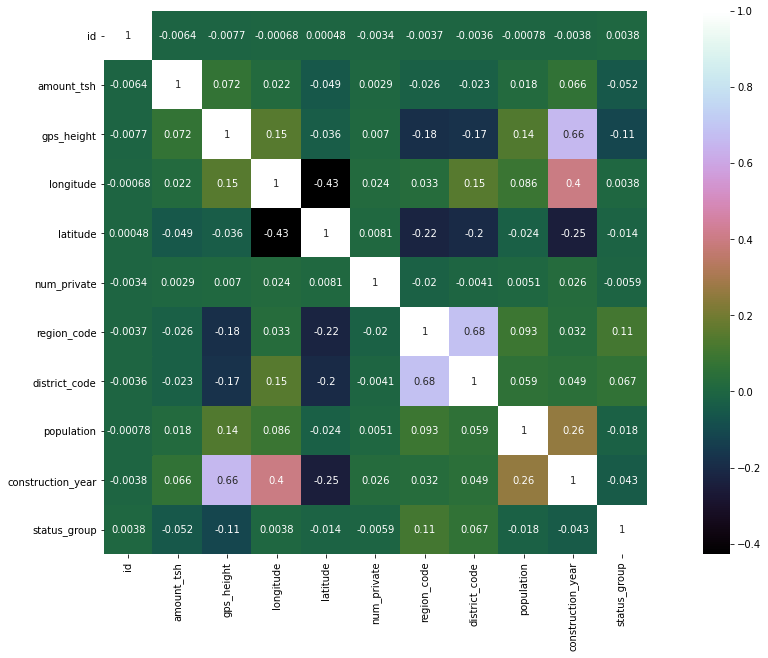

In [ ]:
corr_mat=train.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [ ]:
missing_percentage=(train.isna().sum()/len(train)).sort_values(ascending=False)
missing_percentage

status_group_per_construction_year    0.0
status_group_per_lga                  0.0
basin                                 0.0
district_code                         0.0
extraction_type                       0.0
extraction_type_class                 0.0
gps_height                            0.0
latitude                              0.0
lga                                   0.0
longitude                             0.0
management                            0.0
management_group                      0.0
payment                               0.0
payment_type                          0.0
population                            0.0
quantity                              0.0
recorded_by                           0.0
region                                0.0
region_code                           0.0
source                                0.0
source_class                          0.0
source_type                           0.0
water_quality                         0.0
waterpoint_type                   

In [ ]:
to_drop=["num_private","ward","wpt_name","construction_year","date_recorded","id","scheme_name","scheme_management","installer","funder","public_meeting","permit","subvillage","quantity_group","quality_group","extraction_type_group"]


In [ ]:
Y=train.status_group
ids=test["id"]

In [ ]:
all_data = pd.concat((train, test)).reset_index(drop = True)


In [ ]:
new=train.groupby('lga')['status_group'].agg({'status_group_per_lga':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='lga',right_on='lga')

#new=train.groupby('ward')['status_group'].agg({'status_group_per_ward':'mean'})
#all_data = pd.merge(all_data,new,how='left',left_on='ward',right_on='ward')

new=train.groupby('construction_year')['status_group'].agg({'status_group_per_construction_year':'mean'})
all_data = pd.merge(all_data,new,how='left',left_on='construction_year',right_on='construction_year')



In [ ]:
all_data=all_data.drop(to_drop,axis=1)

In [ ]:
train= all_data[:len(Y)]
test= all_data[len(Y):]

In [ ]:
test=test.drop("status_group",axis=1)
train=train.drop("status_group",axis=1)

In [ ]:
train.shape

(50490, 26)

In [ ]:
train=pd.get_dummies(train)

In [ ]:
train=train.drop("lga_Nyamagana",axis=1)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train,Y , test_size=0.20, random_state=4)

# Modelling

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(colsample_bytree=0.4,
                 learning_rate=0.1,
                 max_depth=12,
                 min_child_weight=1.5,
                 n_estimators=500,                                                                   
                 subsample=0.6,
                 seed=42)
lgb_model.fit(train_X,train_y)
val_pred_lgb = lgb_model.predict_proba(val_X)
print(val_pred_lgb)

[[3.44690562e-01 2.23239455e-02 6.32985493e-01]
 [4.15544993e-03 2.36587253e-04 9.95607963e-01]
 [9.89603926e-01 4.58047358e-03 5.81560089e-03]
 ...
 [3.49918177e-01 5.12550712e-01 1.37531111e-01]
 [9.25183370e-01 3.36500820e-03 7.14516221e-02]
 [1.89218930e-01 9.16148291e-03 8.01619587e-01]]


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_X, train_y)
clf.predict_proba(val_X)

array([[0.47750295, 0.05705773, 0.46543932],
       [0.53076644, 0.03620637, 0.43302719],
       [0.64496383, 0.07089659, 0.28413958],
       ...,
       [0.4862557 , 0.05801361, 0.45573069],
       [0.66507748, 0.07223621, 0.2626863 ],
       [0.55311833, 0.08154754, 0.36533414]])

In [ ]:

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 


In [ ]:
num_labels = 3
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(267,)))
model.add(Activation('relu'))
#model.add(Dropout(0.1))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
lb1 = LabelEncoder()
train_y1 = np_utils.to_categorical(lb1.fit_transform(train_y))

lb2 = LabelEncoder()
val_y1 = np_utils.to_categorical(lb2.fit_transform(val_y))
print(val_X.shape,val_y.shape)

(10098, 267) (10098,)


In [ ]:
model.fit(train_X, train_y1, batch_size=200, epochs=20, validation_data=(val_X, val_y1))

Train on 40392 samples, validate on 10098 samples
Epoch 1/20
40392/40392 [==============================] - 2s 57us/step - loss: 1.0371 - acc: 0.5551 - val_loss: 0.8031 - val_acc: 0.6424
Epoch 2/20
40392/40392 [==============================] - 1s 32us/step - loss: 0.7821 - acc: 0.6507 - val_loss: 0.7745 - val_acc: 0.6528
Epoch 3/20
40392/40392 [==============================] - 1s 32us/step - loss: 0.7447 - acc: 0.6679 - val_loss: 0.7279 - val_acc: 0.6877
Epoch 4/20
40392/40392 [==============================] - 1s 33us/step - loss: 0.7246 - acc: 0.6848 - val_loss: 0.7286 - val_acc: 0.6766
Epoch 5/20
40392/40392 [==============================] - 1s 33us/step - loss: 0.6977 - acc: 0.7030 - val_loss: 0.6875 - val_acc: 0.7180
Epoch 6/20
40392/40392 [==============================] - 1s 33us/step - loss: 0.6763 - acc: 0.7175 - val_loss: 0.6969 - val_acc: 0.7018
Epoch 7/20
40392/40392 [==============================] - 1s 34us/step - loss: 0.6623 - acc: 0.7259 - val_loss: 0.6882 - val_acc

# Testing

In [ ]:
test=pd.get_dummies(test)

In [ ]:
test.shape

(8910, 266)

In [ ]:
test_preds_nn=model.predict(test)


In [ ]:
test_preds_nn

array([[9.9621528e-01, 2.9929653e-03, 7.9170836e-04],
       [8.2197392e-01, 3.2078225e-02, 1.4594793e-01],
       [7.9152614e-01, 6.0615949e-02, 1.4785793e-01],
       ...,
       [9.2097050e-01, 1.8131154e-02, 6.0898270e-02],
       [6.9492133e-03, 1.8080332e-03, 9.9124277e-01],
       [4.5281794e-02, 7.8271609e-03, 9.4689101e-01]], dtype=float32)

In [ ]:
l=[]
test_list=test_preds_nn.tolist()
for i in range(len(test_list)):
  k=test_list[i].index(max(test_list[i]))
  l.append(k+1)
test_preds_nn=l

output = pd.DataFrame({'id': ids, 'damage_grade': (test_preds_nn)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP7/sub_nn.csv', index=False)

In [ ]:
test_preds_lr=clf.predict_proba(test)

l=[]
test_list=test_preds_lr.tolist()
for i in range(len(test_list)):
  k=test_list[i].index(max(test_list[i]))
  l.append(k+1)
test_preds_lr=l

output = pd.DataFrame({'id': ids, 'damage_grade': (test_preds_lr)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP7/sub_lr.csv', index=False)

In [ ]:
test_preds_lgb=lgb_model.predict_proba(test)

l=[]
test_list=test_preds_lgb.tolist()
for i in range(len(test_list)):
  k=test_list[i].index(max(test_list[i]))
  l.append(k+1)
test_preds_lgb=l

output = pd.DataFrame({'id': ids, 'damage_grade': (test_preds_lgb)})
output.to_csv('/content/drive/My Drive/DATACEPT COMP7/sub_lgb.csv', index=False)